# TAAR – Ensemble Learning

Currently we have four different addon recommenders in TAAR. The goal of this project is to combine them into one model. In Machine Learning, this is known as an ensemble model. Generally, ensembles work well if the individual models are quite diverse. There is a good chance that this is the case here as our individual models are all based on different features.

The method that we're trying to implement here is known as *linear stacking* or *linear blending*. Our ensemble model uses the output of the previous models as features and learns to weight them, i.e. it learns how useful the individual recommenders are in general. To do this, we have to extend the existing recommenders so that they're able to return weighted recommendations (meaning pairs of recommendations and confidence scores, instead of just an ordered list).

In [1]:
sc.addPyFile("./taar/dist/mozilla_taar-0.0.16.dev15+g824aa58.d20171018-py2.7.egg")

## Collecting and preprocessing the data

### Retrieving the relevant variables from the longitudinal dataset

In [2]:
%%time
frame = sqlContext.sql("""
WITH valid_clients AS (
    SELECT *
    FROM longitudinal
    WHERE normalized_channel='release' AND build IS NOT NULL AND build[0].application_name='Firefox'
),

addons AS (
    SELECT client_id, feature_row.*
    FROM valid_clients
    LATERAL VIEW explode(active_addons[0]) feature_row
),
    
non_system_addons AS(
    SELECT client_id, collect_set(key) AS installed_addons
    FROM addons
    WHERE NOT value.is_system
    GROUP BY client_id
)

SELECT
    l.client_id,
    non_system_addons.installed_addons,
    settings[0].locale AS locale,
    geo_city[0] AS geo_city,
    subsession_length[0] AS subsession_length,
    system_os[0].name AS os,
    scalar_parent_browser_engagement_total_uri_count[0].value AS total_uri,
    scalar_parent_browser_engagement_tab_open_event_count[0].value as tab_open_count,
    places_bookmarks_count[0].sum as bookmark_count,
    scalar_parent_browser_engagement_unique_domains_count[0].value as unique_tlds,
    profile_creation_date[0] as profile_date,
    submission_date[0] as submission_date
FROM valid_clients l LEFT OUTER JOIN non_system_addons
ON l.client_id = non_system_addons.client_id
""")

rdd = frame.rdd

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 2min 29s


In [3]:
rdd = rdd.cache()

## RDD partitions

For some reason, Spark doesn't correctly adjust the number of partitions in our RDD here. This makes it extremely slow to process the data because we're only using one core instead of `number of cores`  (typically 16 here) times `number of nodes`. Because of this, we manually repartition the RDD here. This will dramatically speed things up when having a cluster with multiple nodes.

In [4]:
rdd.getNumPartitions()

2166

In [5]:
rdd = frame.rdd.repartition(sc.defaultParallelism)

In [6]:
rdd.getNumPartitions()

320

### Loading addon data (AMO)

In [7]:
import boto3
import json
import logging

from botocore.exceptions import ClientError

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

AMO_DUMP_BUCKET = 'telemetry-parquet'
AMO_DUMP_KEY = 'telemetry-ml/addon_recommender/addons_database.json'

In [8]:
def load_amo_external_whitelist():
    """ Download and parse the AMO add-on whitelist.
    :raises RuntimeError: the AMO whitelist file cannot be downloaded or contains
                          no valid add-ons.
    """
    final_whitelist = []
    amo_dump = {}
    try:
        # Load the most current AMO dump JSON resource.
        s3 = boto3.client('s3')
        s3_contents = s3.get_object(Bucket=AMO_DUMP_BUCKET, Key=AMO_DUMP_KEY)
        amo_dump = json.loads(s3_contents['Body'].read())
    except ClientError:
        logger.exception("Failed to download from S3", extra={
            "bucket": AMO_DUMP_BUCKET,
            "key": AMO_DUMP_KEY})

    # If the load fails, we will have an empty whitelist, this may be problematic.
    for key, value in amo_dump.items():
        addon_files = value.get('current_version', {}).get('files', {})
        # If any of the addon files are web_extensions compatible, it can be recommended.
        if any([f.get("is_webextension", False) for f in addon_files]):
            final_whitelist.append(value['guid'])

    if len(final_whitelist) == 0:
        raise RuntimeError("Empty AMO whitelist detected")

    return final_whitelist

### Filtering out legacy addons

The collaborative recommender should make recommendations based on WebExtensions. In general, our ensemble should also only recommend WebExtensions. Because of this, we need a way to filter for WebExtensions. We store this collection in two different data structures (list, set) as both will be useful in the remainder of the notebook.

In [9]:
whitelist = load_amo_external_whitelist()
whiteset = set(whitelist)

INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTP connection (1): 169.254.169.254
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com


In [10]:
def get_whitelisted_addons(installed_addons):
    return whiteset.intersection(installed_addons)

### Completing client data

In [11]:
from dateutil.parser import parse as parse_date
from datetime import datetime

In [12]:
def compute_weeks_ago(formatted_date):
    try:
        date = parse_date(formatted_date).replace(tzinfo=None)
    except ValueError: # raised when the date is in an unknown format
        return float("inf")
    
    days_ago = (datetime.today() - date).days
    return days_ago / 7

In [13]:
def complete_client_data(client_data):
    client = client_data.asDict()
    
    addons = client['installed_addons'] or []
    client['installed_addons'] = get_whitelisted_addons(addons)
    client['disabled_addons_ids'] = addons
    
    client['locale'] = str(client['locale'])
    client['profile_age_in_weeks'] = compute_weeks_ago(client['profile_date'])
    client['submission_age_in_weeks'] = compute_weeks_ago(client['submission_date'])
    
    return client

In [14]:
completed_rdd = rdd.map(complete_client_data).cache()

## Computing confidence scores

We add a method `get_weighted_recommendations` to each recommender. This method returns a (default) dictionary where the keys are addons and the values indicate how confident the recommender is that the respective addon would be a good recommendation.

A default dictionary is used to return `0 ` if a recommender is not in a position to judge how good a potential recommendation would be. The scores returned by this method do not need to be normalized. This is done one step afterwards.

**Important note**: The code below is not directly used in the rest of the notebook, it's just here for explanatory and documentation reasons. To use the adapted classes on the worker nodes, they need to be in the TAAR egg, because pickle seems to have problems with subclassing here. Thus, the code below is copied into the TAAR folder from where the TAAR egg is produced.

In [15]:
from collections import defaultdict
from operator import itemgetter

### Collaborative Recommender

For the collaborative recommender, we use the confidence scores that were already used internally before. These are based on singular value decomposition: A generator job finds good feature representations for addons and computes the feature values for each addon. By looking at the addons that a user already has installed, we can then find feature values that indicate what kind of addons the user likes. After that, we can compute the confidence scores for addons by calculating the distance between their feature values and the feature values of the user.

In [16]:
from taar.recommenders import CollaborativeRecommender

In [17]:
import numpy as np
import operator as op

In [18]:
def java_string_hashcode(s):
    h = 0
    for c in s:
        h = (31 * h + ord(c)) & 0xFFFFFFFF
    return ((h + 0x80000000) & 0xFFFFFFFF) - 0x80000000


def positive_hash(s):
    return java_string_hashcode(s) & 0x7FFFFF

In [19]:
class NewCollaborativeRecommender(CollaborativeRecommender):
    def recommend(self, client_data, limit):
        recommendations = self.get_weighted_recommendations(client_data)
        
        # Sort the suggested addons by their score and return the sorted list of addon
        # ids.
        sorted_dists = sorted(recommendations.items(), key=op.itemgetter(1), reverse=True)
        return [s[0] for s in sorted_dists[:limit]]
    
    def get_weighted_recommendations(self, client_data):
        # Addons identifiers are stored as positive hash values within the model.
        installed_addons =\
            [positive_hash(addon_id) for addon_id in client_data.get('installed_addons', [])]

        # Build the query vector by setting the position of the queried addons to 1.0
        # and the other to 0.0.
        query_vector = np.array([1.0 if (entry.get("id") in installed_addons) else 0.0
                                 for entry in self.raw_item_matrix])

        # Build the user factors matrix.
        user_factors = np.matmul(query_vector, self.model)
        user_factors_transposed = np.transpose(user_factors)

        # Compute the distance between the user and all the addons in the latent
        # space.
        distances = {}
        for addon in self.raw_item_matrix:
            # We don't really need to show the items we requested. They will always
            # end up with the greatest score. Also filter out legacy addons from the
            # suggestions.
            hashed_id = str(addon.get("id"))
            if (hashed_id in installed_addons or
                    hashed_id not in self.addon_mapping or
                    self.addon_mapping[hashed_id].get("isWebextension", False) is False):
                continue

            dist = np.dot(user_factors_transposed, addon.get('features'))
            # Read the addon ids from the "addon_mapping" looking it
            # up by 'id' (which is an hashed value).
            addon_id = self.addon_mapping[hashed_id].get("id")
            distances[addon_id] = dist

        return defaultdict(int, distances)

### Similarity Recommender

Again, we already have some kind of confidence scores internally that we can reuse for the ensemble. These scores are based on a similarity measure: We find similar users to the current users (e.g. by comparing their locale, OS, number of bookmarks, etc.) and recommend their addons. The confidence score for an addon is then computed by summing up the similarity scores of all users that have the respective addon installed.

**TODO**: Compute logarithm

In [20]:
from taar.recommenders.similarity_recommender import SimilarityRecommender

In [21]:
from scipy.spatial.distance import hamming, canberra

In [22]:
def cdist(dist, A, b):
    return np.array([dist(a, b) for a in A])

In [23]:
CATEGORICAL_FEATURES = ["geo_city", "locale", "os"]
CONTINUOUS_FEATURES = ["subsession_length", "bookmark_count", "tab_open_count", "total_uri", "unique_tlds"]

class NewSimilarityRecommender(SimilarityRecommender):
    def get_similar_donors(self, client_data):
        """Computes a set of :float: similarity scores between a client and a set of candidate
        donors for which comparable variables have been measured.
        A custom similarity metric is defined in this function that combines the Hamming distance
        for categorical variables with the Canberra distance for continuous variables into a
        univariate similarity metric between the client and a set of candidate donors loaded during
        init.
        :param client_data: a client data payload including a subset fo telemetry fields.
        :return: the sorted approximate likelihood ratio (np.array) corresponding to the
                 internally computed similarity score and a list of indices that link
                 each LR score with the related donor in the |self.donors_pool|.
        """
        client_categorical_feats = [client_data.get(specified_key) for specified_key in CATEGORICAL_FEATURES]
        client_continuous_feats = [client_data.get(specified_key) for specified_key in CONTINUOUS_FEATURES]

        # Compute the distances between the user and the cached continuous
        # and categorical features.
        cont_features = cdist(canberra, self.continuous_features, client_continuous_feats)
        
        # The lambda trick is needed to prevent |cdist| from force-casting the
        # string features to double.
        cat_features = cdist(hamming, self.categorical_features, client_categorical_feats)

        # Take the product of similarities to attain a univariate similarity score.
        # Addition of 0.001 to the continuous features avoids a zero value from the
        # categorical variables, allowing categorical features precedence.
        distances = (cont_features + 0.001) * cat_features

        # Compute the LR based on precomputed distributions that relate the score
        # to a probability of providing good addon recommendations.
        lrs_from_scores =\
            np.array([self.get_lr(distances[i]) for i in range(self.num_donors)])

        # Sort the LR values (descending) and return the sorted values together with
        # the original indices.
        indices = (-lrs_from_scores).argsort()
        return lrs_from_scores[indices], indices

    def get_weighted_recommendations(self, client_data):
        recommendations = defaultdict(int)

        for donor_score, donor in zip(*self.get_similar_donors(client_data)):
            for addon in self.donors_pool[donor]['active_addons']:
                recommendations[addon] += donor_score
        
        return recommendations

### Locale Recommender

The confidence scores for the locale recommender are based on the number of addon installations in the respective locale. The more often an addon was installed in the locale, the higher its confidence score. We normalize the results for each locale separately, i.e. the most popular addon in each locale will have a confidence score of 1.

In [24]:
from taar.recommenders import LocaleRecommender

In [25]:
TOP_ADDONS_BY_LOCALE_FILE_PATH = "top_addons_by_locale.json"

In [26]:
class NewLocaleRecommender(LocaleRecommender):
    def __init__(self, TOP_ADDONS_BY_LOCALE_FILE_PATH):
        OriginalLocaleRecommender.__init__(self)
        
        with open(TOP_ADDONS_BY_LOCALE_FILE_PATH) as data_file:
            top_addons_by_locale = json.load(data_file)
            
        self.top_addons_by_locale = defaultdict(lambda: defaultdict(int), top_addons_by_locale)
        
    def get_weighted_recommendations(self, client_data):
        client_locale = client_data.get('locale', None)
        return defaultdict(int, self.top_addons_by_locale[client_locale])

### Legacy Recommender

For the legacy recommender, we count how often an addon is listed as a replacement for an installed legacy addon. This count is a natural number that's directly used as the confidence score.

In [27]:
from taar.recommenders import LegacyRecommender

In [28]:
class NewLegacyRecommender(LegacyRecommender):
    def get_weighted_recommendations(self, client_data):
        recommendations = defaultdict(int)
        addons = client_data.get('disabled_addons_ids', [])
        
        for addon in addons:
            for replacement in self.legacy_replacements.get(addon, []):
                recommendations[replacement] += 1
                
        return recommendations

## Choosing training, validation and test sets

For training and validation purposes, only clients that have WebExtension addons installed are useful.

The [evaluation notebook](https://github.com/florian/taar-prototyping/blob/master/evaluation.ipynb) lists the portion of clients with a certain number of whitelisted addons. If the cut-off is set to `>= 3` or `>= 4` very few clients are left.

In [29]:
useful_clients = completed_rdd.filter(lambda client: len(client['installed_addons']) >= 1).cache()

In [30]:
useful_clients.count()

435313

These users are useful for training and evaluating our model:

In [31]:
training, test = useful_clients.randomSplit([0.8, 0.2])

## Masking addons

First, we'll introduce a small helper function `random_partition`. It takes in an iterable `A` that should be partitioned into to new lists where the first list has a length of `k`. This partitioning is done randomly.

In [32]:
from random import sample

In [33]:
def random_partition(A, k):
    n = len(A)
    A = list(A)
    indices = set(sample(range(n), k))
    
    first = []
    second = []
    
    for i in range(n):
        element = A[i]
        
        if i in indices:
            first.append(element)
        else:
            second.append(element)
            
    return first, second

Next, we can use this function to randomly decide on a subset of addons that we want to mask for a user.

In [34]:
def get_num_masked(addons):
    return max(1, len(addons) / 2)

In [35]:
def mask_addons(client):
    addons = client['installed_addons']
    num_mask = get_num_masked(addons)
    
    masked, unmasked = random_partition(addons, num_mask)
    
    client['installed_addons'] = unmasked
    client['masked_addons'] = masked
    
    return client

In [36]:
training_masked = training.map(mask_addons).cache()

## Creating the feature matrices

For each user, we want a matrix that contains a row for each whitelisted addon and a column for each recommender. A cell then contains the confidence score that the respective recommender gave for the respective user and addon.

In [37]:
recommenders = {
    "collaborative": CollaborativeRecommender(),
    "similarity": SimilarityRecommender(),
    "locale": LocaleRecommender("./top_addons_by_locale.json"),
    "legacy": LegacyRecommender()
}

INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:boto3.resources.action:Calling s3:get_object with {u'Bucket': 'telemetry-parquet', u'Key': 'taar/similarity/donors.json'}
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:boto3.resources.action:Calling s3:get_object with {u'Bucket': 'telemetry-parquet', u'Key': 'taar/similarity/lr_curves.json'}
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:boto3.resources.action:Calling s3:get_object with {u'Bucket': 'telemetry-parquet', u'Key': 'taar/locale/top10_dict.json'}
INFO:botocore.vendored.requests.packages.urllib3.connectionpool:Starting new HTTPS connection (1): s3-us-west-2.amazonaws.com
INFO:boto3.resources.a

In [38]:
def compute_features(client_data):
    recommendations = []
    matrix = []
    
    for _, recommender in recommenders.items():
        recommendations.append(recommender.get_weighted_recommendations(client_data))

    for addon in whitelist:
        matrix.append([features[addon] for features in recommendations])

    return client_data, np.array(matrix)

In [46]:
X_unnormalized = training_masked.map(compute_features).cache()

## Normalization

The optimization algorithms that we use here are much more minimal than what you typically from highly optimized ML libs. Because of this, we need to take special care of properly preprocessing the data.

In the following, we perform these operations:
- [Min-Max scaling](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- Changing the locale scores to a double square root

In [ ]:
max_feature_values = X_unnormalized.map(lambda (_, features): np.max(features, axis=0)).reduce(np.maximum)

In [ ]:
def preprocess_locale_scores(scores):
    return np.sqrt(np.sqrt(scores))

In [ ]:
def scale_features((client, features)):
    features = features / max_feature_values
    features[:, 0] = preprocess_locale_scores(features[:, 0])
    return client, features

In [ ]:
X = X_unnormalized.map(scale_features).cache()

## Making recommendations

Computing recommendations then reduces down to a dot product. These results are then sorted.

In [ ]:
def get_weighted_recommendations(client_data, features, weights):
    scores = features.dot(weights)
    return client_data, np.argsort(-scores)

## Measuring the performance (MAP)

We use the [MAP](https://nlp.stanford.edu/IR-book/html/htmledition/evaluation-of-ranked-retrieval-results-1.html) measure as an error metric for this optimization problem. The reason for this is mostly that we only have positive data, i.e. we know addons which users like, but we don't really have a lot of data about addons that users hate.

In [ ]:
def average_precision(client_data, recommendations):
    tp = fp = 0.
    masked = set(client_data['masked_addons'])
    precisions = []
    
    for recommendation in recommendations:
        if whitelist[recommendation] in masked:
            tp += 1
            precisions.append(tp / (tp + fp))
            if tp == len(masked):
                break
        else:
            fp += 1
    
    if len(precisions) > 0:
        return np.mean(precisions)
    else:
        return 0.

## Training an ensemble model

In [57]:
from scipy.optimize import minimize

### Defining a cost function

We find recommendations, compute the average precision (AP) and then calculate the mean of that (MAP). This produces a value between 0 and 1. We then subtract this value from 1 because SciPy looks for a function to minimize, not to maximize.

In [58]:
def cost(weights, X=X):
    weighted_recommendations = X.map(lambda (client_data, features):
                get_weighted_recommendations(client_data, features, weights)
               )
    
    AP = weighted_recommendations.map(lambda (client_data, recommendations):
             average_precision(client_data, recommendations)
            )
        
    MAP = AP.mean()
            
    return 1 - MAP

### Choosing an initial guess

There are many ways of choosing initial guesses. A constant vector of 1s seems to be a sensible prior (with properly normalized features it means that all recommenders are equally useful). However, randomly choosing initial values can also be useful.

In [59]:
def get_initial_guess_alternative(n):
    return np.ones(n)

In [60]:
def get_initial_guess(n):
    return np.random.random(n)

### Logging the optimization process

SciPy is logging the optimization process to a stdout stream that Jupyter seems to ignore. Because it's extremely useful to see how the optimization process is actually going, we define a helper function that queries `cost` and then also prints the results.

In [61]:
def verbose_cost(weights):
    new_cost = cost(weights)
    print "New guess:", weights, "leads to a cost of", new_cost
    return new_cost

### Optimizing

The 4-element vectors in the following correspond to the recommenders in this order:

In [62]:
recommenders.keys()

['locale', 'legacy', 'collaborative', 'similarity']

We're using the [COBYLA](https://en.wikipedia.org/wiki/COBYLA) algorithm for optimization. There is no theoretical reason for this, it just seems to work pretty well here and finds good results fairly quickly. Of course other algorithms could be used instead of COBYLA here.

In [72]:
num_features = len(recommenders)
x0 = get_initial_guess(num_features)
print "Initial guess:", x0
best_weights = minimize(verbose_cost, x0, method="COBYLA", tol=1e-5).x

Initial guess: [ 0.92298266  0.80952834  0.47482559  0.93028254]
New guess: [ 0.92298266  0.80952834  0.47482559  0.93028254] leads to a cost of 0.70481583848
New guess: [ 1.92298266  0.80952834  0.47482559  0.93028254] leads to a cost of 0.683259673786
New guess: [ 1.92298266  1.80952834  0.47482559  0.93028254] leads to a cost of 0.682828731505
New guess: [ 1.92298266  1.80952834  1.47482559  0.93028254] leads to a cost of 0.677545615984
New guess: [ 1.92298266  1.80952834  1.47482559  1.93028254] leads to a cost of 0.704320141592
New guess: [ 2.54277091  1.8219189   1.62672706  0.16045467] leads to a cost of 0.644513981539
New guess: [ 3.10869844  1.83493605  1.7863102  -0.64830352] leads to a cost of 0.653830802141
New guess: [ 2.82573467  1.82842748  1.70651863 -0.24392442] leads to a cost of 0.650168526742
New guess: [ 2.34803908  1.8219189   1.62672706  0.00367612] leads to a cost of 0.644276588671
New guess: [ 2.64621403  1.82843916  1.70666192 -0.38959174] leads to a cost of 0

### Experimental: Grid search

In [147]:
from itertools import product

In [148]:
def grid_search(cost, parameter_space):
    for parameters in parameter_space:
        print parameters, cost(parameters)

In [151]:
space = product(range(3), repeat=4)
grid_search(cost, space)

(0, 0, 0, 0) 0.999317795469
(0, 0, 0, 1) 0.781044284439
(0, 0, 0, 2) 0.781044284439
(0, 0, 1, 0) 0.943562693329
(0, 0, 1, 1) 0.775298736943
(0, 0, 1, 2) 0.777014400398
(0, 0, 2, 0) 0.943562693329
(0, 0, 2, 1) 0.767080292565
(0, 0, 2, 2) 0.775298736943
(0, 1, 0, 0) 0.995510515481
(0, 1, 0, 1) 0.781035766119
(0, 1, 0, 2) 0.780880352461
(0, 1, 1, 0) 0.943214127322
(0, 1, 1, 1) 0.775202154909
(0, 1, 1, 2) 0.776862986849
(0, 1, 2, 0) 0.943034455897
(0, 1, 2, 1) 0.766951549013
(0, 1, 2, 2) 0.775129598268
(0, 2, 0, 0) 0.995510515481
(0, 2, 0, 1) 0.781786764264
(0, 2, 0, 2) 0.781035766119
(0, 2, 1, 0) 0.943193566877
(0, 2, 1, 1) 0.776209558464
(0, 2, 1, 2) 0.776919897482
(0, 2, 2, 0) 0.943214127322
(0, 2, 2, 1) 0.76798319702
(0, 2, 2, 2) 0.775202154909
(1, 0, 0, 0) 0.653586710269
(1, 0, 0, 1) 0.706249773598
(1, 0, 0, 2) 0.713821595475
(1, 0, 1, 0) 0.650420413684
(1, 0, 1, 1) 0.704830022379
(1, 0, 1, 2) 0.713027854432
(1, 0, 2, 0) 0.650320396078
(1, 0, 2, 1) 0.703943832142
(1, 0, 2, 2) 0.712374

## Comparison to old the method

To validate if the MAP numbers that we get are any good, it's useful to compare them to the results of the previous recommendation process. The following is a minimal reimplementation of this `RecommendationManager`. It's used here because we want to use our masked data instead of the data fetched from HBase.

In [216]:
class RecommendationManager:
    def __init__(self, recommenders):
        self.recommenders = recommenders
        
    def recommend(self, client_data, limit):
        recommendations = []
        
        for r in self.recommenders:
            recommendations += r.recommend(client_data, limit)
            
            if len(recommendations) >= limit:
                break
            
        return recommendations[:limit]

This helper function is similar to `map(superlist.index, sublist`) but ignores elements from the sublist that don't appear in the superlist.

In [217]:
def list_elements_to_indices(superlist, sublist):
    result = []
    
    for a in sublist:
        for i, b in enumerate(superlist):
            if a == b:
                result.append(i)
                break
        
    return result

In [218]:
def evaluate_recommendation_manager(mngr, data=training_masked):
    return 1 - data\
        .map(lambda user: (user, mngr.recommend(user, 10)))\
        .map(lambda (user, recommendations): average_precision(user, list_elements_to_indices(whitelist, recommendations)))\
        .mean()

As we can see, the previous recommendation manager performs much worse than our new model:

In [124]:
mngr = RecommendationManager([recommenders["legacy"], recommenders["collaborative"], recommenders["similarity"], recommenders["locale"]])
evaluate_recommendation_manager(mngr)

0.94540781980452748

However, this comparison is a little bit unfair. The locale recommender is generally extremely useful and can be used as a better baseline. With this ordering (where nearly only the locale recommender is queried), we get a much more comparable result. The results are now in the same ballpark and the ensemble is better by around 2%.

In [125]:
mngr = RecommendationManager([recommenders["locale"], recommenders["legacy"], recommenders["collaborative"], recommenders["similarity"]])
evaluate_recommendation_manager(mngr)

0.66339567712705083

In [219]:
mngr = RecommendationManager([recommenders["locale"]])
evaluate_recommendation_manager(mngr)

0.66240704406886164

## Test set

The results using the test set are quite similar:

In [66]:
test_masked = test.map(mask_addons).cache()

In [67]:
X_test_unnormalized = test_masked.map(compute_features).cache()

In [68]:
X_test = X_test_unnormalized.map(scale_features).cache()

In [248]:
evaluate_recommendation_manager(mngr, test_masked)

0.66328519154987853

In [73]:
cost(best_weights, X_test)

0.64123918634900057

## Optimizing on a subset with some manual decisions

When looking at the results so far, it seems like the locale and collaborative recommenders are the most important ones. The legacy recommender is also useful, but it can rarely be used and by using it we don't really optimize for MAP. Changes to the similarity recommender's weight also only lead to a small change.

Because of this, this section first tries to optimize for locale/collaborative weights using a grid search. Afterwards, we fix these weights and find the best weight for the similarity recommender. This grid search is quite expensive, so we'll work on a smaller subset of the data.

Generally, the results using the subset are in the same ballpark, but of course there are still some differences.

**Disclaimer:** This section is very much experimental and the code is not perfectly refactored

In [74]:
from itertools import product

In [75]:
X_full = X

In [76]:
X = X_full.sample(False, 0.1).cache()

In [80]:
n = 65
locale = np.linspace(0.2, 2.5, num=n)
collaborative = np.linspace(0.2, 2.5, num=n)

In [81]:
%time z = [cost([x, 1., y, .11], X) for x, y in product(locale, collaborative)]

CPU times: user 4min 57s, sys: 24.4 s, total: 5min 22s
Wall time: 27min 26s


In [82]:
xx, yy = np.meshgrid(locale, collaborative)
x = xx.ravel()
y = yy.ravel()

This plot isn't really informative, because there are some areas with very bad parameters which lead to the plot being mostly blue.

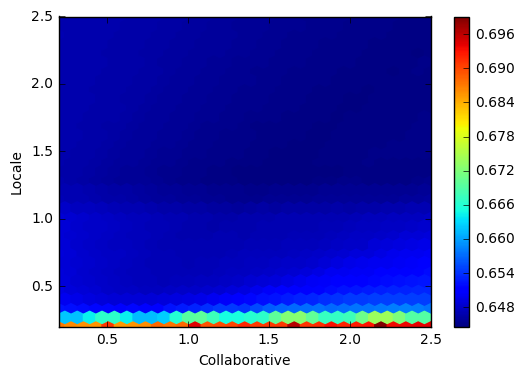

In [87]:
hb = plt.hexbin(x, y, C=z, gridsize=30, cmap='jet')
plt.colorbar(hb)
plt.xlabel("Collaborative")
plt.ylabel("Locale")
plt.show()

To fix this, we can cut off all the results with cost > 0.65, which creates this much more interpretable result:

In [83]:
z2 = np.minimum(z, 0.65)

In [85]:
import matplotlib.pyplot as plt
%matplotlib inline

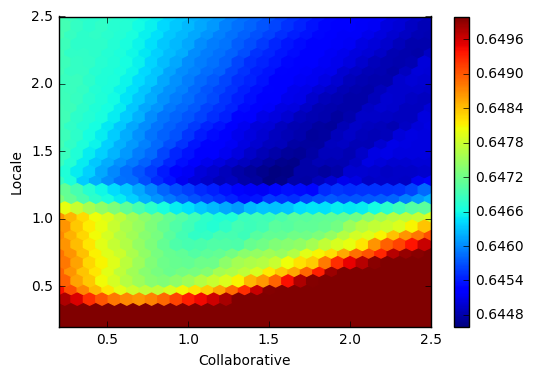

In [86]:
hb = plt.hexbin(x, y, C=z2, gridsize=30, cmap='jet')
plt.colorbar(hb)
plt.xlabel("Collaborative")
plt.ylabel("Locale")
plt.show()

The optimum seems to be around (1.3, 1.8).

In [88]:
list(product(locale, collaborative))[1995]

(1.278125, 1.8171874999999997)

Next, we can try to find the best argument for the similarity recommender when fixing the other weights.

In [89]:
x = np.linspace(0, 0.2, num=100)

In [90]:
y = [cost([1.278125, 1., 1.8171874999999997, xi], X) for xi in x]

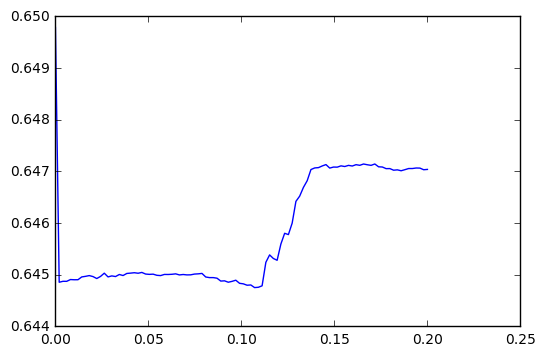

In [91]:
plt.plot(x, y)

In [92]:
x[np.argmin(y)]

0.10707070707070707

When evaluating on all of the data, this doesn't really improve the recommender though.

In [95]:
cost([1.278125, 1., 1.8171874999999997, 0.10707070707070707], X_test)

0.64153074985822722